# Amazon SageMaker - Debugging With Rules
[SageMaker](https://aws.amazon.com/sagemaker/) is managed platform to build, train and host maching learning models. SageMaker Debugger is a new feature which offers the capability to debug machine learning models during training by identifying and detecting problems with the models in near real time. 

## How does SageMaker Debugger work?

SageMaker Debugger lets you go beyond just looking at scalars like losses and accuracies during training and gives you full visibility into all tensors 'flowing through the graph' during training. Furthermore, it helps you monitor your training in near real time using rules and would provide you alerts, once it has detected inconsistency in training flow.

### Concepts
* **Tensors**: These represent the state of the training network at intermediate points during its execution
* **Debug Hook**: Captures the tensors flowing through the training computational graph every N steps.
* **Debugging Rule**: Logic to analyze the tensors captured by the hook and report anamolies, if at all.

With these concepts in mind, let's understand the overall flow of things which the Debugger uses to orchestrate debugging

### Storage of tensors

The tensors captured by the debug hook are stored in an S3 location specified by you. There are two ways you can configure the Debugger for storage:

#### With no changes to your training script
If you use any one of SageMaker provided [Deep Learning Containers](https://docs.aws.amazon.com/sagemaker/latest/dg/pre-built-containers-frameworks-deep-learning.html) then you don't need to make any changes to your training script for the tensors to be stored. SageMaker Debugger will use the configuration you provide in the framework `Estimator` to save the tensors in the fashion you specify.

#### Orchestrating your script to store tensors
 The Debugger exposes a library which allows you to capture these tensors and save them for analysis. It's highly customizable and allows to save the specific tensors you want at different frequencies and possibly with other configurations. Refer [DeveloperGuide](https://github.com/awslabs/sagemaker-debugger/tree/master/sagemaker-docs) for details on how to use the Debugger library with your choice of framework in your training script.

### Analysis of tensors

Once the tensors are saved, the Debugger can be configured to run debugging ***Rules*** on them. On a very broad level, a rule is a python code used to detect certain conditions during training. Some of the conditions that a data scientist training an algorithm may care about are monitoring for gradients getting too large or too small, detecting overfitting, and so on. Sagemaker-Debugger will come pre-packaged with certain first-party (1P) rules. Users can write their own rules using the Sagemaker-Debugger APIs. You can also analyze raw tensor data outside of the Rules construct in say, a Sagemaker notebook, using Sagemaker-Debugger's full set of APIs.

## Setup

Follow this one time setup to get your notebook up and running to use SageMaker Debugger

In [ ]:
! pip install smdebug

With the setup out of the way let's start training our MXNet model in SageMaker with the debugger enabled

## Training TensorFlow models in SageMaker with SageMaker Debugger

### SageMaker TensorFlow as a framework

We'll train a TensorFlow model in this notebook with Sagemaker-Debugger enabled and monitor the training jobs with Sagemaker-Debugger Rules. This will be done using SageMaker [TensorFlow 1.15.0](https://docs.aws.amazon.com/sagemaker/latest/dg/pre-built-containers-frameworks-deep-learning.html) Container as a framework


In [134]:
import boto3
import os
import sagemaker
from sagemaker.tensorflow import TensorFlow

Let's import the libraries needed for our demo of SageMaker debugger

In [135]:
from sagemaker.debugger import Rule, DebuggerHookConfig, TensorBoardOutputConfig, CollectionConfig
import smdebug_rulesconfig as rule_configs

Now we'll define the configuration for our training to run. We'll using image recognition using MNIST dataset as our training example.

In [144]:
# define the entrypoint script
entrypoint_script='src/mnist-tensorflow.py'

hyperparameters = {
    "num_epochs": "100"
}

### Setting up the Estimator

Now it's time to setup our TensorFlow estimator. We've added new parameters to the estimator to enable your training job for debugging through SageMaker Debugger. These new parameters are explained below

* **debugger_hook_config**: This new parameter accepts a local path where you wish your tensors to be written to and also accepts the S3 Uri where you wish your tensors to be uploaded to. SageMaker will take care of uploading these tensors transparently during execution.
* **rules**: This new parameter will accept a list of rules you wish to evaluate against the tensors output by this training job. For rules, SageMaker Debugger supports two types:
 * **SageMaker Rules**: These are rules specially curated by the data science and engineering teams in Amazon SageMaker which you can opt to evaluate against your training job.
 * **Custom Rules**: You can optionally choose to write your own rule as a Python source file and have it evaluated against your training job. To provide SageMaker Debugger to evaluate this rule, you would have to provide the S3 location of the rule source and the evaluator image.
 
#### Using SageMaker Rules
 
In this example we'll demonstrate how to use SageMaker rules to be evaluated against your training. You can find the list of SageMaker rules and the configurations best suited for using them [here](https://github.com/awslabs/sagemaker-debugger-rulesconfig)

The rules we'll use are **VanishingGradient** and **LossNotDecreasing**. As the names suggest, the rules will attempt to evaluate if there are vanishing gradients in the tensors captured by the debugging hook during training and also if the loss is not decreasing.

In [145]:
rules=[Rule.sagemaker(rule_configs.vanishing_gradient()), Rule.sagemaker(rule_configs.loss_not_decreasing())]
estimator = TensorFlow(
    role=sagemaker.get_execution_role(),
    base_job_name='smdebugger-demo-mnist-tensorflow',
    train_instance_count=1,
    train_instance_type='ml.m4.xlarge',
    image_name=cpu_training_image,
    entry_point=entrypoint_script,
    framework_version='1.15',
    py_version='py3',
    train_max_run=3600,
    script_mode=True,
    hyperparameters=hyperparameters,
    sagemaker_session=sess,
    ## New parameter
    rules = rules
)

*Note that Sagemaker-Debugger is only supported for py_version='py3' currently.*

Let's start the training by calling `fit()` on the TensorFlow estimator

In [146]:
# After calling fit, SageMaker will spin off 1 training job and 1 rule job for you
# The rule evaluation status(es) will be visible in the training logs
# at regular intervals

estimator.fit(wait=False)

## Result 

As a result of calling the `fit()` SageMaker debugger kicked off a rule evaluation job for our custom gradient logic in parallel with the training job that was monitoring the tensors output by the training job. As you can see, in the summary, there was no step in the training which reported vanishing gradients in the tensors. Although, the loss was not found to be decreasing at step 1900.

In [173]:
estimator.latest_training_job.rule_job_summary()

[{'RuleConfigurationName': 'VanishingGradient',
  'RuleEvaluationJobArn': 'arn:aws:sagemaker:us-west-2:072677473360:processing-job/smdebugger-demo-mnist-tens-vanishinggradient-f1ae1314',
  'RuleEvaluationStatus': 'InProgress',
  'LastModifiedTime': datetime.datetime(2019, 12, 1, 2, 22, 36, 63000, tzinfo=tzlocal())},
 {'RuleConfigurationName': 'LossNotDecreasing',
  'RuleEvaluationJobArn': 'arn:aws:sagemaker:us-west-2:072677473360:processing-job/smdebugger-demo-mnist-tens-lossnotdecreasing-5d4b40d7',
  'RuleEvaluationStatus': 'IssuesFound',
  'StatusDetails': 'RuleEvaluationConditionMet: Evaluation of the rule LossNotDecreasing at step 3000 resulted in the condition being met\n',
  'LastModifiedTime': datetime.datetime(2019, 12, 1, 2, 22, 36, 63000, tzinfo=tzlocal())}]

Let's try and look at the logs of the rule job for loss not decreasing. To do that, we'll use this utlity function to get a link to the rule job logs

In [163]:
def _get_rule_job_name(training_job_name, rule_configuration_name, rule_job_arn):
        """Helper function to get the rule job name with correct casing"""
        return "{}-{}-{}".format(
            training_job_name[:26], rule_configuration_name[:26], rule_job_arn[-8:]
        )
    
def _get_cw_url_for_rule_job(rule_job_name, region):
    return "https://{}.console.aws.amazon.com/cloudwatch/home?region={}#logStream:group=/aws/sagemaker/ProcessingJobs;prefix={};streamFilter=typeLogStreamPrefix".format(region, region, rule_job_name)


def get_rule_jobs_cw_urls(estimator):
    training_job = estimator.latest_training_job
    training_job_name = training_job.describe()["TrainingJobName"]
    rule_eval_statuses = training_job.describe()["DebugRuleEvaluationStatuses"]
    
    result={}
    for status in rule_eval_statuses:
        if status.get("RuleEvaluationJobArn", None) is not None:
            rule_job_name = _get_rule_job_name(training_job_name, status["RuleConfigurationName"], status["RuleEvaluationJobArn"])
            result[status["RuleConfigurationName"]] = _get_cw_url_for_rule_job(rule_job_name, boto_session.region_name)
    return result

get_rule_jobs_cw_urls(estimator)

{'VanishingGradient': 'https://us-west-2.console.aws.amazon.com/cloudwatch/home?region=us-west-2#logStream:group=/aws/sagemaker/ProcessingJobs;prefix=smdebugger-demo-mnist-tens-VanishingGradient-f1ae1314;streamFilter=typeLogStreamPrefix',
 'LossNotDecreasing': 'https://us-west-2.console.aws.amazon.com/cloudwatch/home?region=us-west-2#logStream:group=/aws/sagemaker/ProcessingJobs;prefix=smdebugger-demo-mnist-tens-LossNotDecreasing-5d4b40d7;streamFilter=typeLogStreamPrefix'}

## Data Analysis - Manual
Now that we have trained the system we can analyze the data. Here we focus on after-the-fact analysis of the rule job confguration "LossNotDecreasing"

We import a basic analysis library, which defines a concept of Trial that represents a single training run.

In [168]:
from smdebug.trials import create_trial

s3_output_path = estimator.latest_training_job.describe()["DebugHookConfig"]["S3OutputPath"] + estimator.latest_training_job.name + '/' + 'debug-output'
trial = create_trial(s3_output_path)

[2019-12-01 02:12:53.151 ip-172-16-53-234:8157 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-us-west-2-072677473360/smdebugger-demo-mnist-tensorflow-2019-12-01-01-58-19-574/debug-output


We can list all the tensors that were recorded to know what we want to plot. Each one of these names is the name of a tensor - the name is a combination of the feature name (which, in these cases, is auto-assigned by TensorFlow) and whether it's an `conv2d` or `dense` value.

In [169]:
trial.tensor_names()

['gradients/conv2d/BiasAdd_grad/tuple/control_dependency_1:0',
 'gradients/conv2d/Conv2D_grad/tuple/control_dependency_1:0',
 'gradients/conv2d_1/BiasAdd_grad/tuple/control_dependency_1:0',
 'gradients/conv2d_1/Conv2D_grad/tuple/control_dependency_1:0',
 'gradients/dense/BiasAdd_grad/tuple/control_dependency_1:0',
 'gradients/dense/MatMul_grad/tuple/control_dependency_1:0',
 'gradients/dense_1/BiasAdd_grad/tuple/control_dependency_1:0',
 'gradients/dense_1/MatMul_grad/tuple/control_dependency_1:0',
 'sparse_softmax_cross_entropy_loss/value:0']

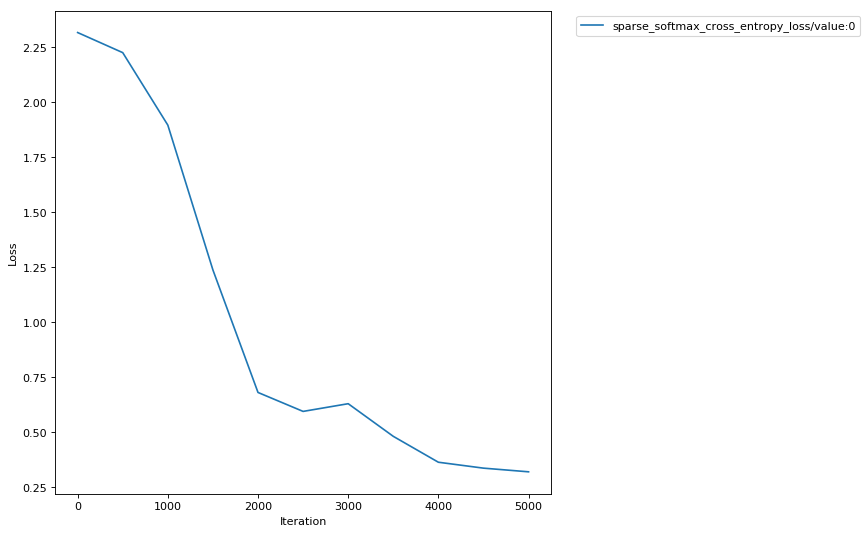

In [170]:
import matplotlib.pyplot as plt
import re

# Define a function that, for the given tensor name, walks through all 
# the iterations for which we have data and fetches the value.
# Returns the set of steps and the values
def get_data(trial, tname):
    tensor = trial.tensor(tname)
    steps = tensor.steps()
    vals = [tensor.value(s) for s in steps]
    return steps, vals

def plot_tensors(trial, regex, ylabel=''):
    """
    Takes a `trial` and plots all tensors that match the given regex.
    """
    plt.figure(
        num=1, figsize=(8, 8), dpi=80,
        facecolor='w', edgecolor='k')

    tensors = trial.tensor_names()

    for tensor_name in sorted(tensors):
        if re.match(regex, tensor_name):
            steps, data = get_data(trial, tensor_name)
            plt.plot(steps, data, label=tensor_name)

    plt.legend(bbox_to_anchor=(1.04,1), loc='upper left')
    plt.xlabel('Iteration')
    plt.ylabel(ylabel)
    plt.show()
    
plot_tensors(trial, "sparse_softmax_cross_entropy_loss/.*", ylabel="Loss")

As expected, you can see a bump at step 3000